# 1) Before you build any model, you want first to explore the raw data. What kind of analyses you would do? What kind of data pre-processing you would do? Please explain your logic and show the result of your preparatory analyses. [Point 7]

In [1]:
#get dataset from github
!git clone https://github.com/i-wijaya-agriaku/agriaku_20230804_qcm_dataset.git

Cloning into 'agriaku_20230804_qcm_dataset'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 18 (delta 7), reused 17 (delta 6), pack-reused 0
Receiving objects: 100% (18/18), 5.86 KiB | 5.86 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [43]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from xgboost import XGBClassifier
from flask import Flask, request, jsonify

In [7]:
# combined all dataset of each cencor into one dataframe
dfs = []
for numer in [3,6,7,10,12]:
  path = f'/content/agriaku_20230804_qcm_dataset/dataset/QCM{numer}.csv'
  print(path)
  df = pd.read_csv(path,delimiter=';')
  df['cencor'] = f'QCM{numer}'
  dfs.append(df)
targets = ['1-Octanol','1-Propanol','2-Butanol','2-propanol','1-isobutanol']
df = pd.concat(dfs,axis=0)
# convert target into 1 columns
df['alcohol_molecule'] = df[targets].idxmax(1)
# drop columns
df = df.drop(targets,axis=1)
# show table
df.head()

/content/agriaku_20230804_qcm_dataset/dataset/QCM3.csv
/content/agriaku_20230804_qcm_dataset/dataset/QCM6.csv
/content/agriaku_20230804_qcm_dataset/dataset/QCM7.csv
/content/agriaku_20230804_qcm_dataset/dataset/QCM10.csv
/content/agriaku_20230804_qcm_dataset/dataset/QCM12.csv


,0.799_0.201_MIP,0.799_0.201_NP,0.700_0.300_MIP,0.700_0.300_NP,0.600_0.400_MIP,0.600_0.400_NP,0.501_0.499_MIP,0.501_0.499_NP,0.400_0.600_MIP,0.400_0.600_NP,cencor,alcohol_molecule
0,-10.06,-10.62,-14.43,-18.31,-24.64,-30.56,-38.62,-45.59,-54.89,-62.28,QCM3,1-Octanol
1,-9.69,-10.86,-16.73,-21.75,-28.47,-35.83,-43.65,-52.43,-61.92,-71.27,QCM3,1-Octanol
2,-12.07,-14.28,-21.54,-27.92,-35.19,-43.94,-52.04,-62.49,-71.97,-83.10,QCM3,1-Octanol
3,-14.21,-17.41,-25.91,-33.36,-41.29,-51.27,-59.94,-71.55,-81.51,-93.83,QCM3,1-Octanol
4,-16.57,-20.35,-29.97,-37.84,-47.03,-57.29,-67.13,-78.96,-90.01,-102.65,QCM3,1-Octanol


0.799_0.201_MIP     0.0
0.799_0.201_NP      0.0
0.700_0.300_MIP     0.0
0.700_0.300_NP      0.0
0.600_0.400_MIP     0.0
0.600_0.400_NP      0.0
0.501_0.499_MIP     0.0
0.501_0.499_NP      0.0
0.400_0.600_MIP     0.0
0.400_0.600_NP      0.0
cencor              0.0
alcohol_molecule    0.0
dtype: float64

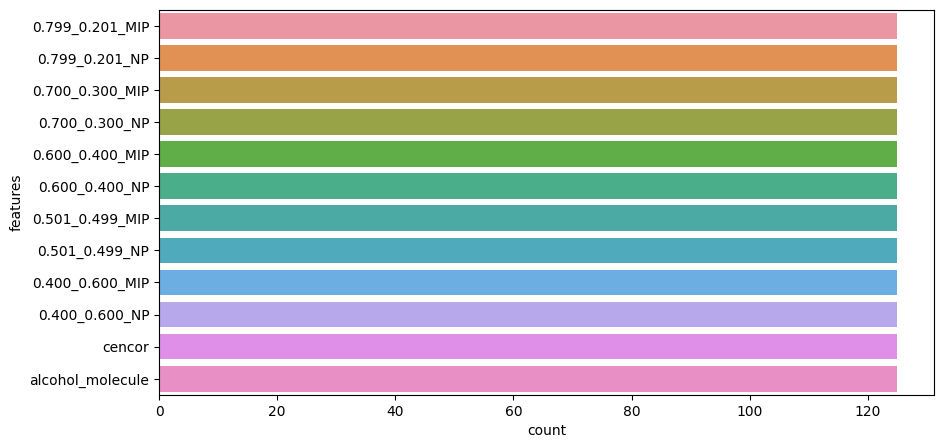

In [11]:
## how many missing values - there 26% of all transactions is not finished only books
features=[]
values=[]
for feats, value in df.isnull().sum().sort_values(ascending=False).items():
    features.append(feats)
    values.append(len(df)-value)
dfcheck = pd.DataFrame(np.array([features,values])).T.rename(columns = {0:'features',1:'count'})
dfcheck['count'] = dfcheck['count'].astype('int64')
#visualize available values each features
plt.figure(figsize=(10,5))
sns.barplot(x='count',y='features',data=dfcheck)
display((df.isnull().sum()/len(df)).sort_values(ascending=False))

['0.799_0.201_MIP',
 '0.799_0.201_NP',
 '0.700_0.300_MIP',
 '0.700_0.300_NP',
 '0.600_0.400_MIP',
 '0.600_0.400_NP',
 '0.501_0.499_MIP',
 '0.501_0.499_NP',
 '0.400_0.600_MIP',
 '0.400_0.600_NP']

In [22]:
feat_outlier = []
for cencor in list(df.cencor.unique()):
  for feature in list(df.drop(['cencor','alcohol_molecule'],axis=1).columns):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3-Q1
    lower_whisker = Q1- 1.5*IQR
    upper_whisker = Q3 + 1.5*IQR
    # checking wheter a column has top outlier ",
    if df[(df[feature] > upper_whisker)].any(axis=None):
        top = 'yes'
        feat_outlier.append(feature)
    else:
        top = 'no'
    # checking wheter a column has top outlier ",
    if df[(df[feature] < lower_whisker)].any(axis=None):
        low = "yes"
        feat_outlier.append(feature)
    else:
        low = "no"
    print(f'the cencor {cencor} with column {feature} has lower_whisker = {lower_whisker} and upper_whisker = {upper_whisker}')
    print(f'this column {feature} has lower outlier = {low} and upper outlier = {top}')
    print("===================================================")

the cencor QCM3 with column 0.799_0.201_MIP has lower_whisker = -131.79 and upper_whisker = 33.01
this column 0.799_0.201_MIP has lower outlier = no and upper outlier = no
the cencor QCM3 with column 0.799_0.201_NP has lower_whisker = -113.46999999999998 and upper_whisker = 11.809999999999988
this column 0.799_0.201_NP has lower outlier = no and upper outlier = no
the cencor QCM3 with column 0.700_0.300_MIP has lower_whisker = -210.41999999999996 and upper_whisker = 56.13999999999998
this column 0.700_0.300_MIP has lower outlier = no and upper outlier = no
the cencor QCM3 with column 0.700_0.300_NP has lower_whisker = -186.765 and upper_whisker = 30.714999999999975
this column 0.700_0.300_NP has lower outlier = no and upper outlier = no
the cencor QCM3 with column 0.600_0.400_MIP has lower_whisker = -306.665 and upper_whisker = 90.815
this column 0.600_0.400_MIP has lower outlier = no and upper outlier = no
the cencor QCM3 with column 0.600_0.400_NP has lower_whisker = -260.45 and uppe

In [27]:
# since the dataset doesnt have outlier then we can directly create final table for modelling
dfs = pd.concat([pd.get_dummies(df['cencor'], columns=['cencor'], prefix='cencor'),df.drop('cencor',axis=1)],axis=1)
dfs.head()

,cencor_QCM10,cencor_QCM12,cencor_QCM3,cencor_QCM6,cencor_QCM7,0.799_0.201_MIP,0.799_0.201_NP,0.700_0.300_MIP,0.700_0.300_NP,0.600_0.400_MIP,0.600_0.400_NP,0.501_0.499_MIP,0.501_0.499_NP,0.400_0.600_MIP,0.400_0.600_NP,alcohol_molecule
0,0,0,1,0,0,-10.06,-10.62,-14.43,-18.31,-24.64,-30.56,-38.62,-45.59,-54.89,-62.28,1-Octanol
1,0,0,1,0,0,-9.69,-10.86,-16.73,-21.75,-28.47,-35.83,-43.65,-52.43,-61.92,-71.27,1-Octanol
2,0,0,1,0,0,-12.07,-14.28,-21.54,-27.92,-35.19,-43.94,-52.04,-62.49,-71.97,-83.10,1-Octanol
3,0,0,1,0,0,-14.21,-17.41,-25.91,-33.36,-41.29,-51.27,-59.94,-71.55,-81.51,-93.83,1-Octanol
4,0,0,1,0,0,-16.57,-20.35,-29.97,-37.84,-47.03,-57.29,-67.13,-78.96,-90.01,-102.65,1-Octanol


In [33]:
Counter(dfs.alcohol_molecule)

Counter({'1-Octanol': 25,
         '1-Propanol': 25,
         '2-Butanol': 25,
         '2-propanol': 25,
         '1-isobutanol': 25})

# 2) Can you build a Machine Learning model (not Artificial Neural Network) to categorize the alcohol molecule given readings from the electronic nose? (Please consider the MIP: NP ratio as one of the features as well) Please justify your choice of algorithm and walk us through your logic as you develop the model. What is the accuracy, precision, and recall of the model? [Point 10]

In [41]:
# Load the dataset (replace with your dataset)
data = dfs.copy()
# Split data into features and target
X = data.drop('alcohol_molecule', axis=1)
y = data['alcohol_molecule']
# Convert target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
################ Training dataset ################
# Preprocessing: Scale numerical features on train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Build the XGBoost model
model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=num_classes  # Number of unique classes in target
)
# Fit the model
model_xgb.fit(X_train_scaled, y_train)
# Predict on the train
y_pred_train = model_xgb.predict(X_train_scaled)
# Calculate accuracy on train
accuracy_train = accuracy_score(y_train, y_pred_train)
################ Testing dataset ################
# Preprocessing: Scale numerical features on test
X_test_scaled = scaler.transform(X_test)
# Predict on the test
y_pred_test = model_xgb.predict(X_test_scaled)
# Calculate accuracy on test
accuracy_test = accuracy_score(y_test, y_pred_test)
# Print classification report
print("Accuracy TRAIN:", accuracy_train)
print("Accuracy TEST:", accuracy_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Accuracy TRAIN: 1.0
Accuracy TEST: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        18

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         7

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00     

# 3) Can you build an Artificial Neural Network (ANN) model to categorize the alcohol molecule given readings from the electronic nose? (Please consider the MIP:NP ratio as one of the features as well) Please justify your choice of algorithm and walk us through your logic as you develop the model. What is the accuracy, precision, and recall of the model? [Point 10]

In [45]:
# Load the dataset (replace with your dataset)
data = dfs.copy()
# Split data into features and target
X = data.drop('alcohol_molecule', axis=1)
y = data['alcohol_molecule']
# Convert target labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

######### Training ##############
# Preprocessing: Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Convert target to one-hot encoded vectors
y_train_onehot = to_categorical(y_train, num_classes)
# Build the deep learning model
model_ANN = Sequential()
model_ANN.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))
model_ANN.add(Dropout(0.3))
model_ANN.add(Dense(64, activation='relu'))
model_ANN.add(Dropout(0.3))
model_ANN.add(Dense(num_classes, activation='softmax'))
# Compile the model
model_ANN.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
# Fit the model
model_ANN.fit(X_train_scaled, y_train_onehot, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
# Evaluate the model on the train set
loss_train, accuracy_train = model_ANN.evaluate(X_train_scaled, y_train_onehot)
# Predict on the train set
y_pred_onehot_train = model_ANN.predict(X_train_scaled)
y_pred_train = y_pred_onehot_train.argmax(axis=1)
# Convert numerical predictions back to original labels
y_pred_labels_train = label_encoder.inverse_transform(y_pred_train)
# Calculate accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
# Calculate micro-averaged precision and recall
micro_precision_train = precision_score(y_train, y_pred_train, average='micro')
micro_recall_train = recall_score(y_train, y_pred_train, average='micro')
# Calculate macro-averaged precision and recall
macro_precision_train = precision_score(y_train, y_pred_train, average='macro')
macro_recall_train = recall_score(y_train, y_pred_train, average='macro')

######### Testing ##############
# Preprocessing: Scale numerical features
X_test_scaled = scaler.transform(X_test)
# Convert target to one-hot encoded vectors
y_test_onehot = to_categorical(y_test, num_classes)
# Evaluate the model on the test set
loss_test, accuracy_test = model_ANN.evaluate(X_test_scaled, y_test_onehot)
# Predict on the test set
y_pred_onehot_test = model_ANN.predict(X_test_scaled)
y_pred_test = y_pred_onehot_test.argmax(axis=1)
# Convert numerical predictions back to original labels
y_pred_labels_test = label_encoder.inverse_transform(y_pred_test)
# Calculate accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
# Calculate micro-averaged precision and recall
micro_precision_test = precision_score(y_test, y_pred_test, average='micro')
micro_recall_test = recall_score(y_test, y_pred_test, average='micro')
# Calculate macro-averaged precision and recall
macro_precision_test = precision_score(y_test, y_pred_test, average='macro')
macro_recall_test = recall_score(y_test, y_pred_test, average='macro')


# Print classification report
print("Train Accuracy:", accuracy_train)
print("Test Accuracy:", accuracy_test)
print("Train Loss:", loss_train)
print("Test Loss:", loss_test)
print("Train Micro-averaged Precision:", micro_precision_train)
print("Test Micro-averaged Precision:", micro_precision_test)
print("Train Micro-averaged Recall:", micro_recall_train)
print("Test Micro-averaged Recall:", micro_recall_test)
print("Train Macro-averaged Precision:", macro_precision_train)
print("Test Macro-averaged Precision:", macro_precision_test)
print("Train Macro-averaged Recall:", macro_recall_train)
print("Test Macro-averaged Recall:", macro_recall_test)
print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


3/3 [==============================] - 1s 196ms/step - loss: 1.6254 - accuracy: 0.2111 - val_loss: 1.5522 - val_accuracy: 0.2000
Epoch 2/20
3/3 [==============================] - 0s 37ms/step - loss: 1.5529 - accuracy: 0.2889 - val_loss: 1.4847 - val_accuracy: 0.3000
Epoch 3/20
3/3 [==============================] - 0s 30ms/step - loss: 1.5289 - accuracy: 0.3333 - val_loss: 1.4384 - val_accuracy: 0.3000
Epoch 4/20
3/3 [==============================] - 0s 38ms/step - loss: 1.3813 - accuracy: 0.3667 - val_loss: 1.4042 - val_accuracy: 0.4000
Epoch 5/20
3/3 [==============================] - 0s 37ms/step - loss: 1.4430 - accuracy: 0.3667 - val_loss: 1.3705 - val_accuracy: 0.4000
Epoch 6/20
3/3 [==============================] - 0s 29ms/step - loss: 1.3538 - accuracy: 0.4000 - val_loss: 1.3408 - val_accuracy: 0.4000
Epoch 7/20
3/3 [==============================] - 0s 52ms/step - loss: 1.3046 - accuracy: 0.4333 - val_loss: 1.3156 - val_accuracy: 0.4000
Epoch 8/20
3/3 [=====================

# 4) You were asked to convert your model to API, so that the researchers can perform the alcohol identification in real-time. How would you do this (you don’t have to make the actual API)? [Point 8]

In [38]:
app = Flask(__name__)
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    features = data['features']
    # Preprocess features
    features_scaled = scaler.transform([features])
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    # Return prediction as JSON
    result = {'prediction': prediction}
    return jsonify(result)
if __name__ == '__main__':
    app.run(debug=True)

In [72]:
################ Apply Model XGB ################
app = Flask(__name__)
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    X_test = data['features']
    # Preprocess features
    X_test_scaled = scaler.transform(X_test)
    # Make prediction
    prediction = model_xgb.predict(X_test_scaled)[0]
    # Return prediction as JSON
    result = {'prediction': prediction}
    return jsonify(result)
if __name__ == '__main__':
    app.run(debug=True)

In [46]:
y_test

array([4, 4, 3, 0, 0, 4, 1, 2, 4, 0, 0, 4, 4, 2, 4, 0, 3, 0, 3, 3, 2, 0,
       0, 0, 1])

In [47]:
to_categorical(y_test, num_classes)

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
################ Apply Model ANN ################
app = Flask(__name__)
@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    X_test = data['features']
    # Preprocess features
    X_test_scaled = scaler.transform(X_test)
    # Make prediction
    y_pred_onehot_test = model_ANN.predict(X_test_scaled)
    y_pred_test = y_pred_onehot_test.argmax(axis=1)
    # Convert numerical predictions back to original labels
    prediction = label_encoder.inverse_transform(y_pred_test)
    # Return prediction as JSON
    result = {'prediction': prediction}
    return jsonify(result)
if __name__ == '__main__':
    app.run(debug=True)